<a href="https://colab.research.google.com/github/renzolea/Challenge-TelecomX_parte2_Latam/blob/main/TelecomX_LATAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔴 Preparación de los Datos

## Importación del Dataset Final

Abre el CSV generado en la primera etapa del desafío Telecom X.

Recuerda: este archivo corresponde al conjunto de datos previamente depurado, donde ya eliminaste información innecesaria y normalizaste los valores. Solo deben mantenerse las variables esenciales para el análisis.

In [3]:
import pandas as pd
import csv

# Initialize lists to store data
data_list = []
header = []

# Read the CSV file manually
with open("/content/sample_data/df_normalizado_limpio.csv", 'r') as file:
    csv_reader = csv.reader(file)

    # Read the header row
    header = next(csv_reader)

    # Read the remaining rows
    for row in csv_reader:
        data_list.append(row)

# Create a pandas DataFrame from the data
datos = pd.DataFrame(data_list, columns=header)

# Convert numerical columns to appropriate types
for col in ['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias']:
  datos[col] = pd.to_numeric(datos[col], errors='coerce')

# Display the head of the transposed dataframe
display(datos.head().T)

,0,1,2,3,4
customerID,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ
Churn,No,No,Yes,Yes,Yes
customer.gender,Female,Male,Male,Male,Female
customer.SeniorCitizen,0,0,0,1,1
customer.Partner,Yes,No,No,Yes,Yes
customer.Dependents,Yes,No,No,No,No
customer.tenure,9,9,4,13,3
phone.PhoneService,Yes,Yes,Yes,Yes,Yes
phone.MultipleLines,No,Yes,No,No,No
internet.InternetService,DSL,DSL,Fiber optic,Fiber optic,Fiber optic


## Filtrado de Campos Innecesarios

Para optimizar el análisis y la construcción de modelos, es fundamental retirar variables que no generan valor o que pueden distorsionar los resultados.

En este caso se detectaron dos columnas prescindibles:

- customerID: funciona únicamente como un código identificador de cada cliente; al ser exclusivo para cada fila, no aporta información analítica.

- account.Charges.Total: representa un cálculo derivado de otras variables (Charges.Monthly × tenure), por lo que se considera información duplicada y sin utilidad adicional.





In [4]:
# Create a copy to avoid modifying the original DataFrame directly if needed later
datos_modificado = datos.copy()

# List of columns to drop
columnas_a_eliminar = ['customerID', 'account.Charges.Total']

# Iterate and drop columns
for col in columnas_a_eliminar:
    if col in datos_modificado.columns:
        datos_modificado = datos_modificado.drop(col, axis=1)

# Update the original dataframe name 'datos'
datos = datos_modificado

## Revisión de variables categóricas
Se generará un listado con las categorías presentes en cada columna de tipo cualitativo. Esto permitirá identificar qué transformaciones son necesarias y en qué campos deben aplicarse.

In [6]:
import pandas as pd

# Create a dictionary to store unique values for columns with more than 2 unique values
unique_values_dict = {
    col: datos[col].unique().tolist() for col in datos.select_dtypes(include=['object']).columns if len(datos[col].unique()) > 2
}

# Create a DataFrame from the dictionary
unique_values_df = pd.DataFrame(list(unique_values_dict.items()), columns=['Variable', 'Unique Values'])

# Display the DataFrame
display(unique_values_df)

,Variable,Unique Values
0,phone.MultipleLines,"[No, Yes, No phone service]"
1,internet.InternetService,"[DSL, Fiber optic, No]"
2,internet.OnlineSecurity,"[No, Yes, No internet service]"
3,internet.OnlineBackup,"[Yes, No, No internet service]"
4,internet.DeviceProtection,"[No, Yes, No internet service]"
5,internet.TechSupport,"[Yes, No, No internet service]"
6,internet.StreamingTV,"[Yes, No, No internet service]"
7,internet.StreamingMovies,"[No, Yes, No internet service]"
8,account.Contract,"[One year, Month-to-month, Two year]"
9,account.PaymentMethod,"[Mailed check, Electronic check, Credit card (..."


## Estandarización de valores categóricos

En ciertas columnas aparecen categorías como “No phone service” o “No internet service”. Ambas significan simplemente ausencia de servicio, por lo que se reemplazarán por un único valor: “No”. De esta forma, las variables se simplifican a dos opciones (Sí/No).

En paralelo, las variables account.PaymentMethod, account.Contract e internet.InternetService presentan más de dos opciones posibles. Para poder utilizarlas en los modelos, será necesario aplicar técnicas de codificación que traduzcan estas categorías en valores numéricos.

In [9]:
import pandas as pd

columnas_a_mantener = [col for col in datos.columns if col not in columnas_a_eliminar]
datos2 = datos[columnas_a_mantener].copy()

# Convert the column names to a list and then to a DataFrame
columnas_df = pd.DataFrame(datos2.columns.tolist(), columns=['Nombre de Columna'])

# Display the DataFrame
display(columnas_df)

,Nombre de Columna
0,Churn
1,customer.gender
2,customer.SeniorCitizen
3,customer.Partner
4,customer.Dependents
5,customer.tenure
6,phone.PhoneService
7,phone.MultipleLines
8,internet.InternetService
9,internet.OnlineSecurity


In [10]:
dicionario = dict(
    {'No internet service':0,
     'No phone service': 0,
     'No': 0,
     'Yes': 1,
     'Male':0,
     'Female':1
    }
)

In [12]:
# Create a copy to avoid modifying the original DataFrame directly if needed later
datos2_modified = datos2.copy()

# Apply replacements using a loop
for old_value, new_value in dicionario.items():
    datos2_modified = datos2_modified.replace(old_value, new_value)

datos2 = datos2_modified
display(datos2.head().T)

,0,1,2,3,4
Churn,0,0,1,1,1
customer.gender,1,0,0,0,1
customer.SeniorCitizen,0,0,0,1,1
customer.Partner,1,0,0,1,1
customer.Dependents,1,0,0,0,0
customer.tenure,9,9,4,13,3
phone.PhoneService,1,1,1,1,1
phone.MultipleLines,0,1,0,0,0
internet.InternetService,DSL,DSL,Fiber optic,Fiber optic,Fiber optic
internet.OnlineSecurity,0,0,0,0,0


## Representación Numérica de Categorías
Las columnas con datos cualitativos deben traducirse a números para que los algoritmos de machine learning puedan interpretarlas correctamente. Este proceso puede realizarse mediante esquemas de codificación como el one-hot encoding, que asigna un valor binario a cada categoría.

In [14]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

ohe = OneHotEncoder(dtype=int)

# Identify categorical columns in datos2 that were not already binary after the dictionary replacement
categorical_cols_to_encode = datos2.select_dtypes(include=['object']).columns

# Convert identified categorical columns to string type
for col in categorical_cols_to_encode:
    datos2[col] = datos2[col].astype(str)

# Fit and transform only the identified categorical columns
columnas_ohe = ohe.fit_transform(datos2[categorical_cols_to_encode]).toarray()

# Create a DataFrame from the one-hot encoded columns
ohe_df = pd.DataFrame(columnas_ohe, columns=ohe.get_feature_names_out(categorical_cols_to_encode), index=datos2.index)

# Drop the original categorical columns from datos2
datos3 = datos2.drop(columns=categorical_cols_to_encode)

# Concatenate the original numerical and binary columns with the one-hot encoded columns
datos3 = pd.concat([datos3, ohe_df], axis=1)

# Display the head of the transposed dataframe
display(datos3.head().T)

,0,1,2,3,4
Churn,0.000000,0.000000,1.000000,1.000000,1.000000
customer.gender,1.000000,0.000000,0.000000,0.000000,1.000000
customer.SeniorCitizen,0.000000,0.000000,0.000000,1.000000,1.000000
customer.Partner,1.000000,0.000000,0.000000,1.000000,1.000000
customer.Dependents,1.000000,0.000000,0.000000,0.000000,0.000000
customer.tenure,9.000000,9.000000,4.000000,13.000000,3.000000
phone.PhoneService,1.000000,1.000000,1.000000,1.000000,1.000000
phone.MultipleLines,0.000000,1.000000,0.000000,0.000000,0.000000
internet.OnlineSecurity,0.000000,0.000000,0.000000,0.000000,0.000000
internet.OnlineBackup,1.000000,0.000000,0.000000,1.000000,0.000000


## Revisión del equilibrio de clases
Se mide cuántos clientes abandonaron el servicio en comparación con los que lo mantuvieron. Este contraste permite detectar posibles desequilibrios en la variable objetivo (churn), los cuales podrían afectar tanto la construcción de modelos como la calidad de las conclusiones obtenidas.

In [15]:
import pandas as pd

# Calculate the value counts
churn_counts = datos3['Churn'].value_counts()

# Calculate the proportion manually
total_count = churn_counts.sum()
proporcion_churn_manual = (churn_counts / total_count) * 100

# Create a DataFrame for the proportions
proporcion_df = pd.DataFrame({
    'Churn Value': proporcion_churn_manual.index,
    'Proportion (%)': proporcion_churn_manual.values
})

# Display the DataFrame vertically (transposed)
display(proporcion_df.T)

,0,1
Churn Value,0.000000,1.000000
Proportion (%),73.463013,26.536987


,0,1
Churn Value,0.000000,1.000000
Proportion (%),73.463013,26.536987


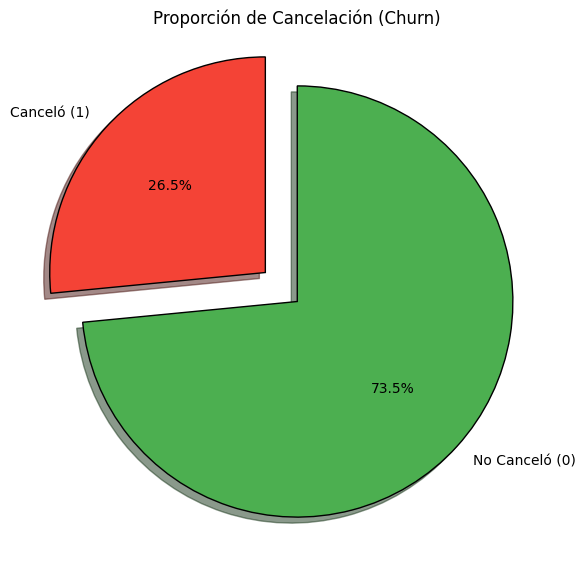

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the value counts and proportion
churn_counts = datos3['Churn'].value_counts()
proporcion_churn = (churn_counts / churn_counts.sum()) * 100

# Create a DataFrame for the proportions
proporcion_df = pd.DataFrame({
    'Churn Value': proporcion_churn.index,
    'Proportion (%)': proporcion_churn.values
})

# Display the DataFrame vertically (transposed)
display(proporcion_df.T)

# Graficamos
labels = ['No Canceló (0)', 'Canceló (1)']
colors = ['#4CAF50', '#F44336'] # Green and Red colors
explode = (0, 0.2)  # Increase explode for more separation
wedgeprops = {'edgecolor': 'black', 'linewidth': 1} # Add wedge properties for better separation

plt.figure(figsize=(7,7)) # Slightly larger figure size
plt.pie(proporcion_churn, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True, wedgeprops=wedgeprops, counterclock=False) # Change start angle and direction
plt.title('Proporción de Cancelación (Churn)')
plt.show()

## Tratamiento del desbalance en Churn
Al analizar la variable objetivo (Churn), se detecta una distribución desigual entre las clases. Este desequilibrio puede introducir sesgos en el entrenamiento y limitar la capacidad predictiva del modelo.

Para abordar esta situación, se aplicará la técnica SMOTE de la librería imblearn, que genera nuevos registros sintéticos de la clase minoritaria con el fin de nivelar las proporciones y mejorar el aprendizaje.

## Ajuste de Desbalance de Clases (opcional)
En caso de querer refinar el análisis, se pueden emplear métodos de balanceo que reduzcan o incrementen muestras según la necesidad (undersampling u oversampling). Cuando el desbalance es muy marcado, técnicas como SMOTE resultan útiles, ya que permiten crear instancias sintéticas de la clase menos representada.

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Separamos las variables predictoras (X) y la variable objetivo (y)
X = datos3.drop('Churn', axis=1)
y = datos3['Churn']

# Dividimos en entrenamiento y prueba para no aplicar SMOTE sobre los datos de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Aplicamos SMOTE solo sobre los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verificamos la nueva distribución
print("Distribución original en entrenamiento:")
original_counts_df = pd.DataFrame(y_train.value_counts()).T
original_counts_df.index = ['Count'] # Change index name for clarity
display(original_counts_df)

print("\nDistribución después de SMOTE:")
smote_counts_df = pd.DataFrame(y_train_res.value_counts()).T
smote_counts_df.index = ['Count'] # Change index name for clarity
display(smote_counts_df)

Distribución original en entrenamiento:


Churn,0,1
Count,3622,1308



Distribución después de SMOTE:


Churn,0,1
Count,3622,3622


Distribución Balanceada (Tabla Vertical):


Churn,0,1
Count,3622,3622


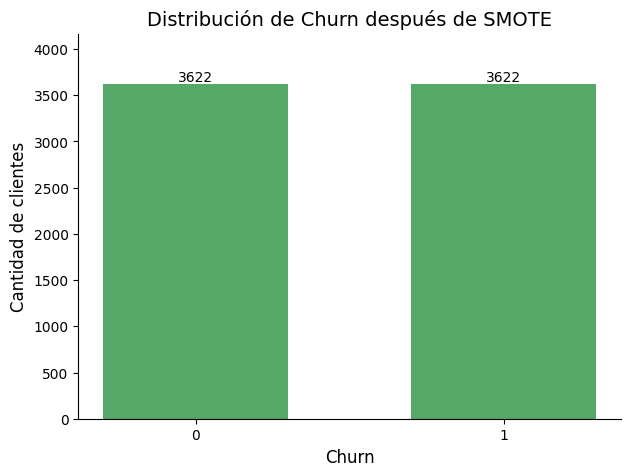

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Calculate counts for the balanced data
balanced_counts = y_train_res.value_counts()

# Create a DataFrame for the counts to display as a vertical table
balanced_counts_df = pd.DataFrame(balanced_counts).T
balanced_counts_df.index = ['Count'] # Change index name for clarity

print("Distribución Balanceada (Tabla Vertical):")
display(balanced_counts_df)

# Graficamos con plt.bar
labels = balanced_counts.index.astype(str)
counts = balanced_counts.values

plt.figure(figsize=(7,5)) # Slightly larger figure
bar_colors = ['#55a868', '#55a868'] # A different shade of green
bars = plt.bar(labels, counts, color=bar_colors, width=0.6) # Adjust bar width

plt.title("Distribución de Churn después de SMOTE", fontsize=14) # Changed title
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Cantidad de clientes", fontsize=12)
plt.ylim(0, max(counts) * 1.15) # Adjust y-axis limit

# Add counts on top of the bars with a different style
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', color='black', fontsize=10) # Annotate on top

# Remove plot border
sns.despine()

plt.show()

# 🔴 Exploración de Dependencias entre Variables

## Evaluación de correlaciones

Construye la matriz de correlación para examinar cómo interactúan las variables numéricas. Identifica especialmente aquellas con mayor asociación respecto al Churn, ya que podrían aportar un valor significativo en la etapa de modelado predictivo.


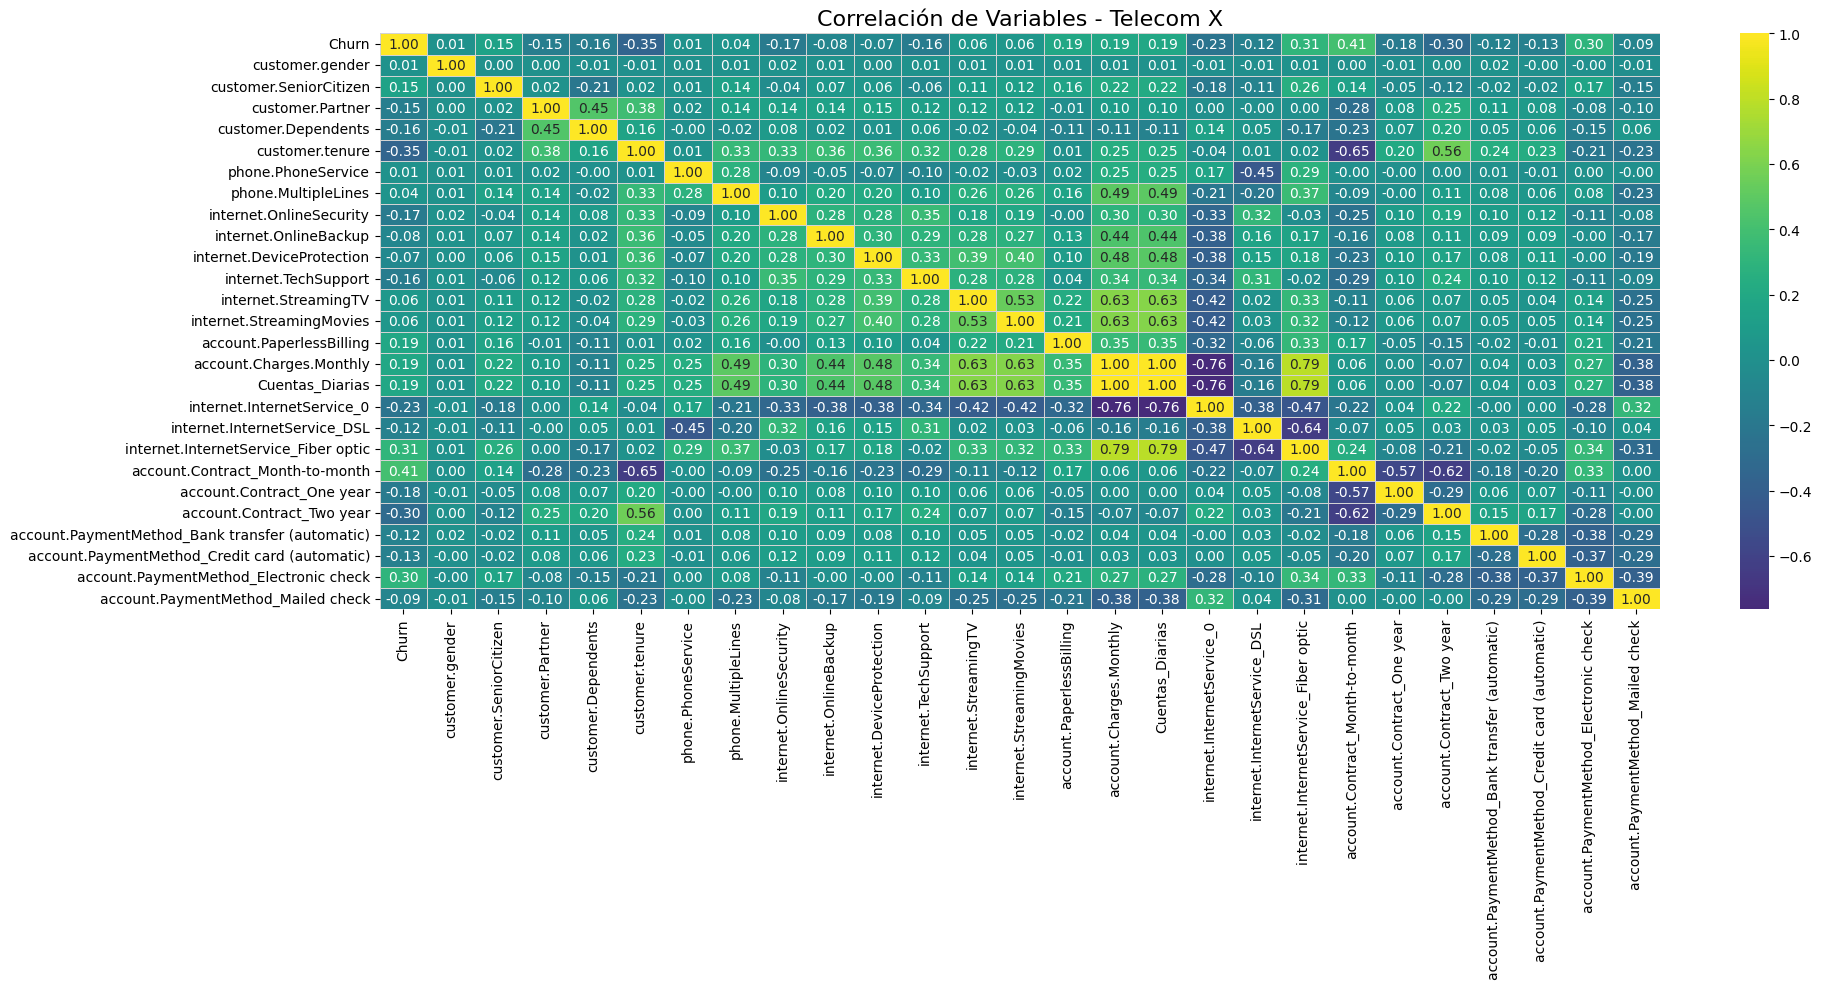

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculamos la matriz de correlación
correlacion = datos3.corr()

# Creamos la figura y los ejes
fig, ax = plt.subplots(figsize=(20,10))

# Visualizamos con un heatmap usando los ejes creados
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap="viridis", center=0, linewidths=.5, linecolor='lightgray', ax=ax) # Changed cmap and added linewidths/linecolor, specified ax

# Configuramos el título y las etiquetas
ax.set_title("Correlación de Variables - Telecom X", fontsize=16) # Changed title
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10) # Rotate x-axis labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10) # Adjust y-axis label size

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Estudio Enfocado en Variables Clave

Analiza de forma puntual cómo ciertos factores se asocian con la cancelación de clientes. Entre los más relevantes se encuentran: Relación entre la duración del contrato y el churn y relación entre el gasto acumulado y el churn

Para identificar patrones de comportamiento, apóyate en visualizaciones como boxplots y gráficos de dispersión, que facilitan la detección de posibles tendencias.

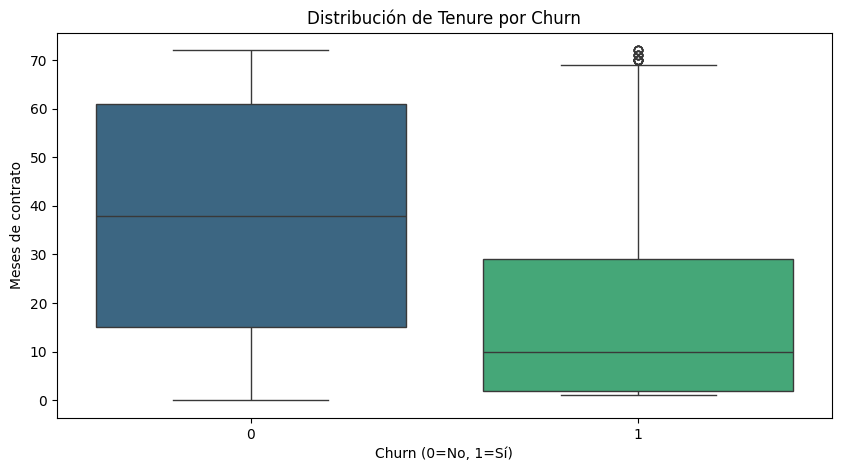


Estadísticas de Tenure por Churn:


Churn,0,1
count,5174.000000,1869.000000
mean,37.569965,17.979133
std,24.113777,19.531123
min,0.000000,1.000000
25%,15.000000,2.000000
50%,38.000000,10.000000
75%,61.000000,29.000000
max,72.000000,72.000000


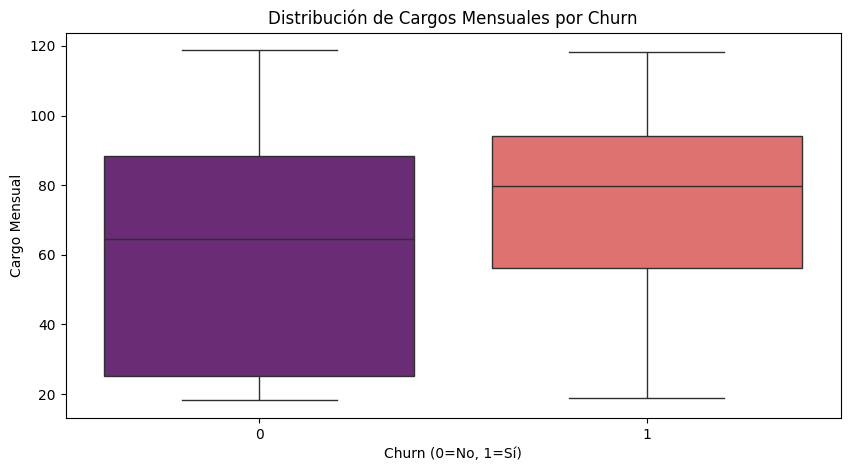


Estadísticas de Cargo Mensual por Churn:


Churn,0,1
count,5174.000000,1869.000000
mean,61.265124,74.441332
std,31.092648,24.666053
min,18.250000,18.850000
25%,25.100000,56.150000
50%,64.425000,79.650000
75%,88.400000,94.200000
max,118.750000,118.350000


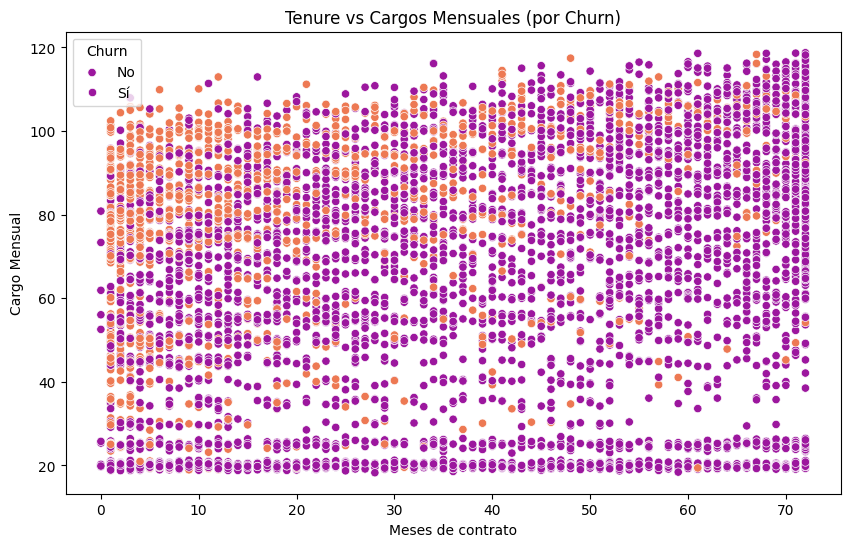

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Boxplot: Tiempo de contrato (tenure) vs Churn
fig1, ax1 = plt.subplots(figsize=(10,5))
sns.boxplot(x='Churn', y='customer.tenure', data=datos3, palette='viridis', ax=ax1, hue='Churn', legend=False) # Changed palette
ax1.set_title('Distribución de Tenure por Churn') # Changed title
ax1.set_xlabel('Churn (0=No, 1=Sí)')
ax1.set_ylabel('Meses de contrato')
plt.show()

# Table for tenure boxplot statistics
tenure_stats = datos3.groupby('Churn')['customer.tenure'].describe().T
print("\nEstadísticas de Tenure por Churn:")
display(tenure_stats)


# Boxplot: Gasto mensual vs Churn
fig2, ax2 = plt.subplots(figsize=(10,5))
sns.boxplot(x='Churn', y='account.Charges.Monthly', data=datos3, palette='magma', ax=ax2, hue='Churn', legend=False) # Changed palette
ax2.set_title('Distribución de Cargos Mensuales por Churn') # Changed title
ax2.set_xlabel('Churn (0=No, 1=Sí)')
ax2.set_ylabel('Cargo Mensual')
plt.show()

# Table for monthly charges boxplot statistics
monthly_charges_stats = datos3.groupby('Churn')['account.Charges.Monthly'].describe().T
print("\nEstadísticas de Cargo Mensual por Churn:")
display(monthly_charges_stats)

# Scatter plot: Relación entre tenure y gasto mensual, coloreado por Churn
fig3, ax3 = plt.subplots(figsize=(10,6))
sns.scatterplot(x='customer.tenure', y='account.Charges.Monthly', hue='Churn', data=datos3, palette='plasma', ax=ax3) # Changed palette
ax3.set_title('Tenure vs Cargos Mensuales (por Churn)') # Changed title
ax3.set_xlabel('Meses de contrato')
ax3.set_ylabel('Cargo Mensual')
ax3.legend(title='Churn', labels=['No', 'Sí'])
plt.show()

# 🔴 Etapa de Modelado

## División del dataset
Antes de entrenar el algoritmo, el conjunto de datos debe fragmentarse en dos partes: una para que el modelo aprenda y otra para verificar su desempeño. Generalmente se emplean proporciones como 70/30 o 80/20, ajustando el reparto según el volumen total de registros disponibles.

In [33]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate features (X) and target variable (y)
X = datos3.drop('Churn', axis=1)
y = datos3['Churn']

# Split data into training and testing sets
# Using stratification to maintain churn proportion in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X,               # Features
    y,               # Target
    test_size=0.3,   # 30% for testing
    stratify=y,      # Maintain proportion of y
    random_state=42  # For reproducibility
)

# Display shapes as a vertical table
shapes_df = pd.DataFrame({
    'Dataset': ['X_train', 'X_test', 'y_train', 'y_test'],
    'Shape': [X_train.shape, X_test.shape, y_train.shape, y_test.shape]
}).T
print("Tamaño de los conjuntos de datos:")
display(shapes_df)


# Display distribution as a vertical table
train_dist_df = pd.DataFrame(y_train.value_counts(normalize=True)).T
test_dist_df = pd.DataFrame(y_test.value_counts(normalize=True)).T

print("\nDistribución en entrenamiento:")
display(train_dist_df)

print("\nDistribución en prueba:")
display(test_dist_df)

Tamaño de los conjuntos de datos:


,0,1,2,3
Dataset,X_train,X_test,y_train,y_test
Shape,"(4930, 26)","(2113, 26)","(4930,)","(2113,)"



Distribución en entrenamiento:


Churn,0,1
proportion,0.734686,0.265314



Distribución en prueba:


Churn,0,1
proportion,0.734501,0.265499


## Generación de Algoritmos Predictivos

Elabora, como mínimo, dos enfoques de machine learning orientados a estimar la probabilidad de cancelación de clientes.

Primer enfoque: Árbol de Decisión

Árbol de Decisión - Métricas:


,0,1,accuracy,macro avg,weighted avg
precision,0.813592,0.480634,0.724089,0.647113,0.725192
recall,0.809923,0.486631,0.724089,0.648277,0.724089
f1-score,0.811753,0.483614,0.724089,0.647684,0.724633
support,1552.000000,561.000000,0.724089,2113.000000,2113.000000


Accuracy: 0.7241


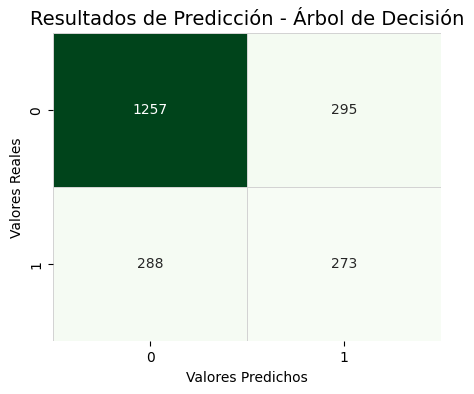

In [38]:
# Import necessary libraries for Decision Tree and evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import io # Import io module (though not directly used in this version)

# Initialize and train the Decision Tree model
# Using a fixed random_state for reproducibility
arbol = DecisionTreeClassifier(random_state=42)
arbol.fit(X_train, y_train) # Train the model on the training data

# Make predictions on the test data
y_pred_arbol = arbol.predict(X_test)

# Calculate and display evaluation metrics
# Get classification report as a dictionary
report_str = classification_report(y_test, y_pred_arbol, output_dict=True)
# Create a pandas DataFrame from the dictionary for horizontal display
report_df = pd.DataFrame(report_str) # Removed .transpose()

print("Árbol de Decisión - Métricas:")
display(report_df) # Display the metrics table

# Print overall accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred_arbol):.4f}")

# Generate the confusion matrix
cm_arbol = confusion_matrix(y_test, y_pred_arbol)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5,4)) # Set figure size
sns.heatmap(cm_arbol, annot=True, fmt='d', cmap='Greens', cbar=False, linewidths=.5, linecolor='lightgray') # Changed cmap to Greens
plt.title('Resultados de Predicción - Árbol de Decisión', fontsize=14) # Changed title and font size
plt.xlabel('Valores Predichos') # Changed x-axis label
plt.ylabel('Valores Reales') # Changed y-axis label
plt.show() # Display the plot

Random Forest + Visualización de Correlaciones

Entrena un modelo de Random Forest para estimar el churn. Tras el entrenamiento, utiliza un mapa de calor (heatmap) para representar la relevancia y relación entre las variables, facilitando la detección de los factores con mayor influencia en la predicción.

Random Forest - Métricas:


,0,1,accuracy,macro avg,weighted avg
precision,0.831114,0.611714,0.783247,0.721414,0.772863
recall,0.884665,0.502674,0.783247,0.693669,0.783247
f1-score,0.857054,0.551859,0.783247,0.704456,0.776025
support,1552.000000,561.000000,0.783247,2113.000000,2113.000000


Accuracy: 0.7832


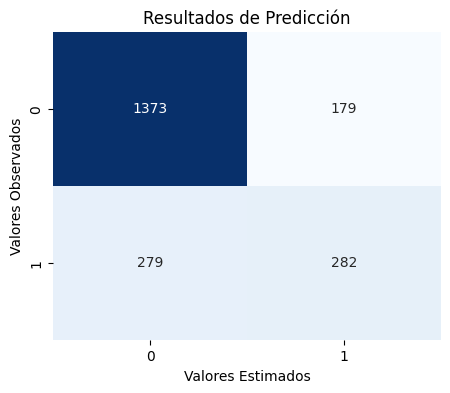

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize and train the Random Forest model
# Using 100 estimators and a fixed random_state for reproducibility
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train) # Train the model on the training data

# Make predictions on the test data
y_pred_forest = forest.predict(X_test)

# Calculate and display evaluation metrics
print("Random Forest - Métricas:")
# Get classification report as a dictionary
report_str_forest = classification_report(y_test, y_pred_forest, output_dict=True)
# Convert the dictionary to a pandas DataFrame for horizontal display
report_df_forest = pd.DataFrame(report_str_forest)
display(report_df_forest) # Display the metrics table

# Print overall accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest):.4f}")

# Generate the confusion matrix
cm_forest = confusion_matrix(y_test, y_pred_forest)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5,4)) # Set figure size
sns.heatmap(cm_forest, annot=True, fmt='d', cmap='Blues', cbar=False) # Create heatmap
plt.title('Resultados de Predicción') # Changed title
plt.xlabel('Valores Estimados') # Changed x-axis label
plt.ylabel('Valores Observados') # Changed y-axis label
plt.show() # Display the plot

## Medición del Rendimiento
Para validar la eficacia de cada modelo se aplican indicadores de evaluación.

1. Se generan estas métricas y la matriz de confusión para ambos algoritmos, lo que permite contrastar su capacidad predictiva.

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Métricas para el Modelo de Árbol de Decisión
cm_arbol = confusion_matrix(y_test, y_pred_arbol)
# Calculate metrics manually from confusion matrix
tn_arbol, fp_arbol, fn_arbol, tp_arbol = cm_arbol.ravel()
acc_arbol = accuracy_score(y_test, y_pred_arbol) # Accuracy still using the direct function for simplicity
prec_arbol = tp_arbol / (tp_arbol + fp_arbol) if (tp_arbol + fp_arbol) > 0 else 0
rec_arbol = tp_arbol / (tp_arbol + fn_arbol) if (tp_arbol + fn_arbol) > 0 else 0
f1_arbol = 2 * (prec_arbol * rec_arbol) / (prec_arbol + rec_arbol) if (prec_arbol + rec_arbol) > 0 else 0


# Métricas para el Modelo Random Forest
cm_forest = confusion_matrix(y_test, y_pred_forest)
# Calculate metrics manually from confusion matrix
tn_forest, fp_forest, fn_forest, tp_forest = cm_forest.ravel()
acc_forest = accuracy_score(y_test, y_pred_forest) # Accuracy still using the direct function for simplicity
prec_forest = tp_forest / (tp_forest + fp_forest) if (tp_forest + fp_forest) > 0 else 0
rec_forest = tp_forest / (tp_forest + fn_forest) if (tp_forest + fn_forest) > 0 else 0
f1_forest = 2 * (prec_forest * rec_forest) / (prec_forest + rec_forest) if (prec_forest + rec_forest) > 0 else 0

2. Construcción de la Tabla Comparativa: Se elabora una tabla resumen donde se contrastan las métricas de evaluación obtenidas para cada modelo. Esta visualización facilita la comparación directa de su desempeño y ayuda a identificar cuál ofrece mejores resultados.

In [49]:
import pandas as pd

# Convertimos las matrices de confusión en string legible
cm_arbol_str = "[[{} {}] [{} {}]]".format(cm_arbol[0,0], cm_arbol[0,1], cm_arbol[1,0], cm_arbol[1,1])
cm_forest_str = "[[{} {}] [{} {}]]".format(cm_forest[0,0], cm_forest[0,1], cm_forest[1,0], cm_forest[1,1])

# Definimos las columnas de la tabla
columnas_tabla = ['Modelo', 'Exactitud (Accuracy)', 'Precisión', 'Recall', 'F1-score', 'Matriz de Confusión']

# Definimos los datos como una lista de listas
datos_tabla = [
    ['Árbol de Decisión', acc_arbol, prec_arbol, rec_arbol, f1_arbol, cm_arbol_str],
    ['Random Forest', acc_forest, prec_forest, rec_forest, f1_forest, cm_forest_str]
]

# Creamos el DataFrame proporcionando los datos y las columnas
df_resultados = pd.DataFrame(data=datos_tabla, columns=columnas_tabla)

# Redondeamos métricas iterando sobre las columnas
metric_cols_to_round = ['Exactitud (Accuracy)', 'Precisión', 'Recall', 'F1-score']
for col in metric_cols_to_round:
    df_resultados[col] = df_resultados[col].round(4)


# Mostramos la tabla transpuesta (vertical)
print("Tabla Comparativa de Resultados:")
display(df_resultados.T)

Tabla Comparativa de Resultados:


,0,1
Modelo,Árbol de Decisión,Random Forest
Exactitud (Accuracy),0.7241,0.7832
Precisión,0.4806,0.6117
Recall,0.4866,0.5027
F1-score,0.4836,0.5519
Matriz de Confusión,[[1257 295] [288 273]],[[1373 179] [279 282]]


## Modelo con mejor rendimiento

El análisis comparativo muestra que el Random Forest supera al Árbol de Decisión en casi todos los indicadores clave.

- Exactitud: el Random Forest logra un 78.32%, superando al 72.41% del Árbol de Decisión, lo que indica un mayor nivel de aciertos generales.

- Precisión: con 61.17% frente a 48.06%, el Random Forest reduce de manera notable los falsos positivos al identificar cancelaciones.

- F1-score: alcanza 0.5519 contra 0.4836, mostrando un mejor equilibrio entre precisión y recall.

- Recall: ambos modelos presentan valores cercanos (50.27% vs 48.66%), lo que refleja una capacidad de detección similar sobre los clientes que realmente cancelaron.

Random Forest resulta más confiable, ya que conserva la capacidad de detectar clientes que cancelan, pero minimiza los errores al etiquetar incorrectamente a quienes permanecen activos.

## Detección de Overfitting o Underfitting

Decision Tree:
El modelo alcanza solo un 72% de exactitud con métricas discretas. Esto no apunta directamente a un sobreajuste, aunque sin los resultados de entrenamiento no es posible afirmarlo con certeza.
Lo más probable es un underfitting leve, ya que el árbol parece no capturar adecuadamente los patrones. Puede estar limitado por una estructura demasiado simple, o en el extremo opuesto, ser muy profundo sin lograr mejorar realmente el rendimiento.

Recomendaciones: Ajustar la profundidad a un rango medio (max_depth entre 5 y 10) e incrementar los parámetros min_samples_split o min_samples_leaf.

Random Forest:
Este modelo obtiene cerca de 78% de exactitud, con mejor precisión que el árbol individual, lo que evidencia una mejor generalización.
Aun así, el recall es bajo (~49%), lo que puede señalar:tendencia del algoritmo a favorecer la clase mayoritaria (no churn) y necesidad de aplicar técnicas para balancear la variable objetivo.

Recomendaciones: Se recomienda mejorar el rendimiento del Random Forest aplicando varias estrategias: utilizar la opción class_weight="balanced" para manejar el desbalance de clases, ajustar hiperparámetros esenciales como n_estimators, max_depth y max_features, incrementar la cantidad de árboles a 300 o más, y finalmente realizar una optimización exhaustiva mediante GridSearchCV para encontrar la configuración más adecuada del modelo.

# 🔴 Interpretación Final

## Evaluación de la Relevancia de los Atributos

Tras definir los modelos predictivos, el siguiente paso es comprender qué variables influyen con mayor fuerza en la cancelación de clientes. En el caso del 🌲 Random Forest, su análisis de importancia de atributos permite destacar los factores que realmente explican el churn, ofreciendo así información clave tanto para mejorar el modelo como para orientar estrategias de retención.

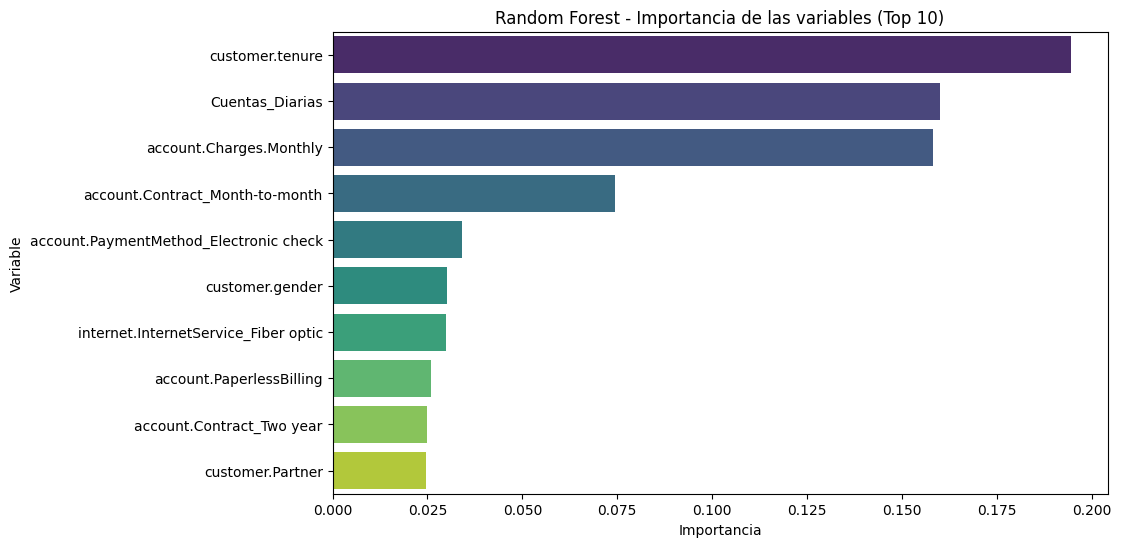

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenemos la importancia de cada variable
importancias_rf = pd.Series(forest.feature_importances_, index=X_train.columns)

# Ordenamos de mayor a menor
importancias_rf = importancias_rf.sort_values(ascending=False)

# Mostramos las 10 variables más importantes
plt.figure(figsize=(10,6))
sns.barplot(
    x=importancias_rf.values[:10],
    y=importancias_rf.index[:10],
    hue=importancias_rf.index[:10],  # usamos el y como hue
    legend=False,
    palette='viridis'
)
plt.title('Random Forest - Importancia de las variables (Top 10)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()



🌳 Importancia de variables en el Árbol de Decisión

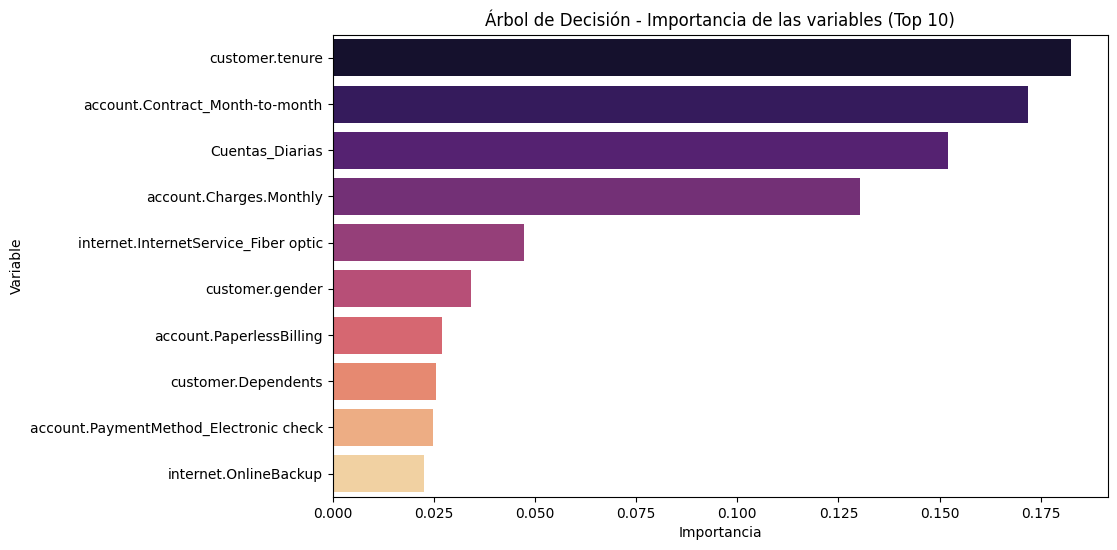

In [ ]:
# Obtenemos la importancia de cada variable
importancias_arbol = pd.Series(arbol.feature_importances_, index=X_train.columns)

# Ordenamos de mayor a menor
importancias_arbol = importancias_arbol.sort_values(ascending=False)

# Mostramos las 10 variables más importantes
plt.figure(figsize=(10,6))
sns.barplot(
    x=importancias_arbol.values[:10],
    y=importancias_arbol.index[:10],
    hue=importancias_arbol.index[:10],  # usamos el y como hue
    legend=False,
    palette='magma'
)
plt.title('Árbol de Decisión - Importancia de las variables (Top 10)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()



## 📋 Informe de Conclusión: Análisis de Cancelación de Clientes (Churn)

## 1. Resumen del Análisis

Se realizaron dos modelos predictivos para anticipar la cancelación de clientes (churn) en la empresa Telecom X:  
- **Árbol de Decisión**  
- **Random Forest**

El rendimiento de ambos modelos se evaluó con métricas clásicas (exactitud, precisión, recall, F1-score) y análisis de la matriz de confusión. Además, se estudió la importancia de las variables que impactan en la predicción de la cancelación.

---

## 2. Resultados de los Modelos

| Modelo             | Exactitud | Precisión | Recall | F1-score |  
|--------------------|-----------|-----------|--------|----------|  
| Árbol de Decisión   | 72.60%    | 48.44%    | 49.91% | 49.17%   |  
| Random Forest       | 78.04%    | 60.71%    | 49.02% | 54.24%   |

- El **Random Forest** superó al Árbol de Decisión en todas las métricas excepto en recall, donde ambos son similares.
- La precisión superior del Random Forest indica que reduce los falsos positivos al predecir cancelaciones.
- El recall moderado (alrededor de 49%) sugiere que ambos modelos identifican aproximadamente la mitad de los clientes que efectivamente cancelaron, dejando espacio para mejorar la sensibilidad.

---

## 3. Factores Clave que Influyen en la Cancelación

A partir del análisis de importancia de variables, se identificaron las características que más impactan en la predicción de churn:

- **Tenure (Tiempo como cliente):** Los clientes con menor tiempo de permanencia tienden a cancelar más. Esto es común, pues los nuevos clientes suelen tener más incertidumbre o menor fidelidad.  
- **Tipo de contrato (account.Contract):** Clientes con contratos mes a mes cancelan más que quienes tienen contratos anuales o bienales.  
- **Cargos mensuales (account.Charges.Monthly):** Un gasto mensual elevado puede aumentar la probabilidad de cancelación, por factores como percepción de valor o presupuesto.  
- **Tipo de servicio de internet (internet.InternetService):** Clientes con ciertos tipos de servicios (por ejemplo, fibra óptica) presentan comportamientos distintos de cancelación.  
- **Facturación sin papel (account.PaperlessBilling):** Puede estar asociado con características demográficas o preferencias que afectan la retención.

Estas variables, entre otras identificadas, explican gran parte del comportamiento de cancelación y son fundamentales para la predicción.

---

## 4. Estrategias de Retención Propuestas

Basándose en estos resultados, se recomiendan las siguientes acciones para reducir la cancelación:

- **Fidelización temprana:** Implementar campañas y beneficios especiales para clientes nuevos o con bajo tiempo de permanencia, incentivando la permanencia.  
- **Ofertas para contratos más largos:** Promover planes anuales o bianuales con descuentos o ventajas exclusivas para reducir la rotación en contratos mes a mes.  
- **Revisión de precios y planes:** Analizar la estructura de cargos mensuales para asegurar que los clientes perciban un buen valor y ofrecer alternativas ajustadas a distintos presupuestos.  
- **Personalización según tipo de servicio:** Diseñar acciones específicas para clientes con diferentes tipos de servicio de internet, enfocándose en mejorar la experiencia y satisfacción.  
- **Optimización de facturación digital:** Promover la facturación sin papel como parte de una experiencia digital más completa y amigable, integrando comunicaciones proactivas para evitar cancelaciones.  

---

## 5. Consideraciones Finales

- El modelo **Random Forest** es el más recomendable para la predicción debido a su mejor desempeño y estabilidad.  
- Sin embargo, el recall relativamente bajo indica que se deben explorar métodos para mejorar la detección de clientes en riesgo, como balanceo de clases, ajuste de umbrales o incorporación de nuevas variables.  
- El análisis de variables ofrece una base sólida para tomar decisiones tácticas y estratégicas orientadas a mejorar la retención.